In [1]:
import os
import cv2
import csv
import pandas as pd
import numpy as np
from constants import DatasetPath
from matplotlib import pyplot as plt

In [2]:
DATASET_PATH = DatasetPath.effectivePath

REAL_NAME_DIR = ["afhq", "celebahq", "coco", "ffhq", "imagenet", "landscape", "lsun", "metfaces", "cycle_gan"]

FAKE_NAME_DIR = ["big_gan", "cips", "cycle_gan", "ddpm", "denoising_diffusion_gan", "diffusion_gan", "face_synthetics", 
                 "gansformer", "gau_gan", "generative_inpainting", "glide", "lama", "latent_diffusion", "mat", "palette", 
                 "pro_gan", "projected_gan", "sfhq", "stable_diffusion", "star_gan", "stylegan1", "stylegan2", "stylegan3",
                 "taming_transformer", "vq_diffusion"]

REAL_NAME_DIR_FILTERED = ["coco"]
FAKE_NAME_DIR_FILTERED = ["big_gan"]

DIR_DATASET = os.listdir(DATASET_PATH)

CSV_REAL_PATH = DATASET_PATH + "real.csv"
CSV_FAKE_PATH = DATASET_PATH + "fake.csv"
TINY_DATASET = DATASET_PATH + "tinydataset.csv"

csv_columns_name = ['filename', 'image_path', 'target', 'category']

In [3]:
for folder in DIR_DATASET:
    if folder not in REAL_NAME_DIR + FAKE_NAME_DIR:
        print("Folder "+folder+" does not exist")

Folder fake.csv does not exist
Folder Fourier does not exist
Folder real.csv does not exist
Folder tinydataset.csv does not exist


In [4]:
current_dir = os.listdir(DATASET_PATH)

def create_real_csv():
    if "real.csv" in current_dir:
        print("real.csv already exists.")
        return
    
    real_csv = pd.DataFrame(columns = csv_columns_name)
    #real_csv.to_csv(CSV_REAL_PATH, index=False)

    for dir in REAL_NAME_DIR:
        with open(DATASET_PATH + dir + "\\metadata.csv", mode='r', newline='') as current_csv:

            current_csv = pd.read_csv(current_csv)
            image_path = current_csv["image_path"]
            image_path = dir + "/" + image_path
            image_path = image_path.replace("/","\\")
            current_csv["image_path"] = image_path
            real_csv = pd.concat([real_csv,current_csv[current_csv['target'] == 0]], ignore_index=True)

    real_csv.to_csv(CSV_REAL_PATH, index=False)
    print("real.csv has been created.")

def create_fake_csv():
    if "fake.csv" in current_dir:
        print("fake.csv already exists.")
        return
    
    fake_csv = pd.DataFrame(columns = csv_columns_name)
    #fake_csv.to_csv(CSV_FAKE_PATH, index=False)

    for dir in FAKE_NAME_DIR:
        with open(DATASET_PATH + dir + "\\metadata.csv", mode='r', newline='') as current_csv:

            current_csv = pd.read_csv(current_csv)
            image_path = current_csv["image_path"]
            image_path = dir + "/" + image_path
            image_path = image_path.replace("/","\\")
            current_csv["image_path"] = image_path
            fake_csv = pd.concat([fake_csv,current_csv[current_csv['target'] != 0]], ignore_index=True)

    fake_csv.to_csv(CSV_FAKE_PATH, index=False)
    print("fake.csv has been created.")
            

In [5]:
create_real_csv()
create_fake_csv()

real.csv already exists.
fake.csv already exists.


In [9]:
dir = "big_gan" 

tiny_csv = pd.DataFrame(columns = csv_columns_name)
#tiny_csv.to_csv(TINY_DATASET, index=False)

with open(DATASET_PATH + dir + "\\metadata.csv", mode='r', newline='') as biggan_csv:
    biggan_csv = pd.read_csv(biggan_csv)
    image_path = biggan_csv["image_path"]
    image_path = dir + "/" + image_path
    image_path = image_path.replace("/","\\")
    biggan_csv["image_path"] = image_path
    tiny_csv = pd.concat([tiny_csv,biggan_csv], ignore_index=True)

    tiny_csv.to_csv(TINY_DATASET, index=False)

with open(DATASET_PATH + "coco" + "\\metadata.csv", mode='r', newline='') as coco_csv:
    coco_csv = pd.read_csv(coco_csv)
    image_path = coco_csv["image_path"]
    image_path = dir + "/" + image_path
    image_path = image_path.replace("/","\\")
    print(image_path)
    coco_csv["image_path"] = image_path
    tiny_csv = pd.concat([tiny_csv,coco_csv.sample(n=10000)], ignore_index=True)
    
    tiny_csv.to_csv(TINY_DATASET, index=False)

0          big_gan/coco/coco2017/test2017/img035341.jpg
1         big_gan/coco/coco2017/train2017/img119746.jpg
2         big_gan/coco/coco2017/train2017/img063452.jpg
3          big_gan/coco/coco2017/test2017/img001799.jpg
4         big_gan/coco/coco2017/train2017/img057033.jpg
                              ...                      
163841    big_gan/coco/coco2017/train2017/img128300.jpg
163842    big_gan/coco/coco2017/train2017/img076803.jpg
163843     big_gan/coco/coco2017/test2017/img026920.jpg
163844     big_gan/coco/coco2017/test2017/img022654.jpg
163845      big_gan/coco/coco2017/val2017/img160178.jpg
Name: image_path, Length: 163846, dtype: object


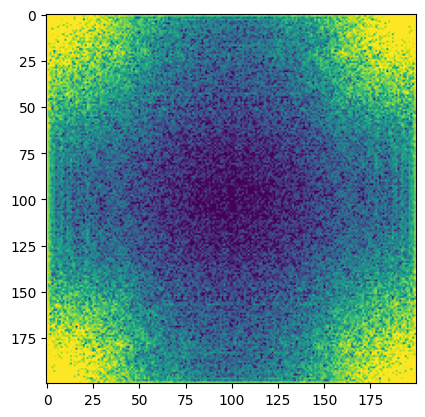

In [16]:
#APPLICO LA TRASFORMATA DI FOURIER

with open(DATASET_PATH  + "\\tinydataset.csv", mode='r', newline='') as tiny_dataset:
    tiny_dataset_csv = pd.read_csv(tiny_dataset)
    row = tiny_dataset_csv.iloc[1]
    
    path = DATASET_PATH + row["image_path"]
    
    RGBimg = cv2.imread(path)
    grayImg = cv2.cvtColor(RGBimg, cv2.COLOR_BGR2GRAY)
    
    fft_img = np.fft.fft2(grayImg)
    fft_img = np.log(np.abs(fft_img))

    fft_min = np.percentile(fft_img, 5)
    fft_max = np.percentile(fft_img, 95)

    #Questa è una normalizzazione che ho trovato su un codice. Serve a mettere in risalto le fingerprint
    if (fft_max - fft_min) <= 0:
        print('ma cosa...')
        fft_img = (fft_img - fft_min) / ((fft_max - fft_min)+np.finfo(float).eps)
    else:
        fft_img = (fft_img - fft_min) / (fft_max - fft_min)
        fft_img = (fft_img - 0.5) * 2
        fft_img[fft_img < -1] = -1
        fft_img[fft_img > 1] = 1
        
    plt.imshow(fft_img)
    plt.show()